# loan_payment_default
## Objective: 
- Predict the probability that a client will default on their next payment and classify clients into risk categories based on an optimized probability threshold. 

## Metrics and considerations:
- We use supervised models. 
- Train a probabilistic classification model (e.g., logistic regression) that outputs the probability of default.
- Evaluate overal ranking performance using ROC-AUC
- Select an operating probability threshold by analyzinv performance across multiple thresholds. 
- For each threshold, compute recall, precision, F1-score and Accuracy. 
- Since defaults are the minority class, prioritize achieving Recall >= 75% while maintaining acceptable Precision.

In [1]:
# Install packages
!pip install kagglehub==0.4.0
!pip install xgboost

In [88]:
# Import libraries. 
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from xgboost import XGBClassifier

In [3]:
# Download latest version
path = kagglehub.dataset_download("yasserh/loan-default-dataset")

df = pd.read_csv(f"{path}/Loan_Default.csv")

Here are some metrics definition for further clarity into the analysis. 
- 'ID': Loan Id.
- 'year': year in which the loan was given.
- 'loan_limit': type of loan limit (conforming/ non-conforming, etc.)
- 'Gender': gender of the main solicitor
- 'approv_in_adv': pre-approved or not. 
- 'loan_type': type of loan. 
- 'loan_purpose': purpose for loan
- 'Credit_Worthiness': solvence of the client. 
- 'open_credit': marks wheather the client has opened credit lines. 
- 'business_or_commercial': indicates if the loan is comercial or not. 
- 'loan_amount': total amount of loan. 
- 'rate_of_interest': interest applied rate
- 'Interest_rate_spread': difference between base and given rate. 
- 'Upfront_charges': Intial charged costs. 
- 'term': loan term
- 'Neg_ammortization': marks wheather the loan allows negative amortization. 
- 'interest_only': marks wheather at the beginning only the interests are payed. 
- 'lump_sum_payment': indicates if there is a big payment at the end. 
- 'property_value': estimated value of property. 
- 'occupancy_type': use of the property. 
- 'Secured_by': Active that secures the loan.
- 'total_units': number of units in the property. 
- 'income': solicitor's income. 
- 'credit_type': Type of credit. 
- 'Credit_Score': credit score of the solicitor. 
- 'co-applicant_credit_type': type of credit history of co-applicant. 
- 'age': age of the solicitor. 
- 'submission_of_application': channel or method through which the solicitude was sent. 
- 'LTV': Loan-to-value. loan vs property value ratio. 
- 'Region': Region of the property. 
- 'Security_Type': type of guarantee
- 'Status': target variable. 
- 'dtir1': debt-to-income ratio. monthly debt vs monthly income ratio. 

In [4]:
# Dataset first exploration
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


Based on our first exploration: 
- We only have data of 2019.
- Data presents missing values.
- Data that has max values considerably bigger than the 75% are: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, property_value, income, income, LTV. Needs further analysis to check for outliers. 
- 24% of our data are default clients, we have highly imbalanced classes.

let's check data distribution. Before that, delete the id and year columns since they don't add much information to the analysis. 

In [5]:
df_new = df.drop(columns=["ID", "year"])

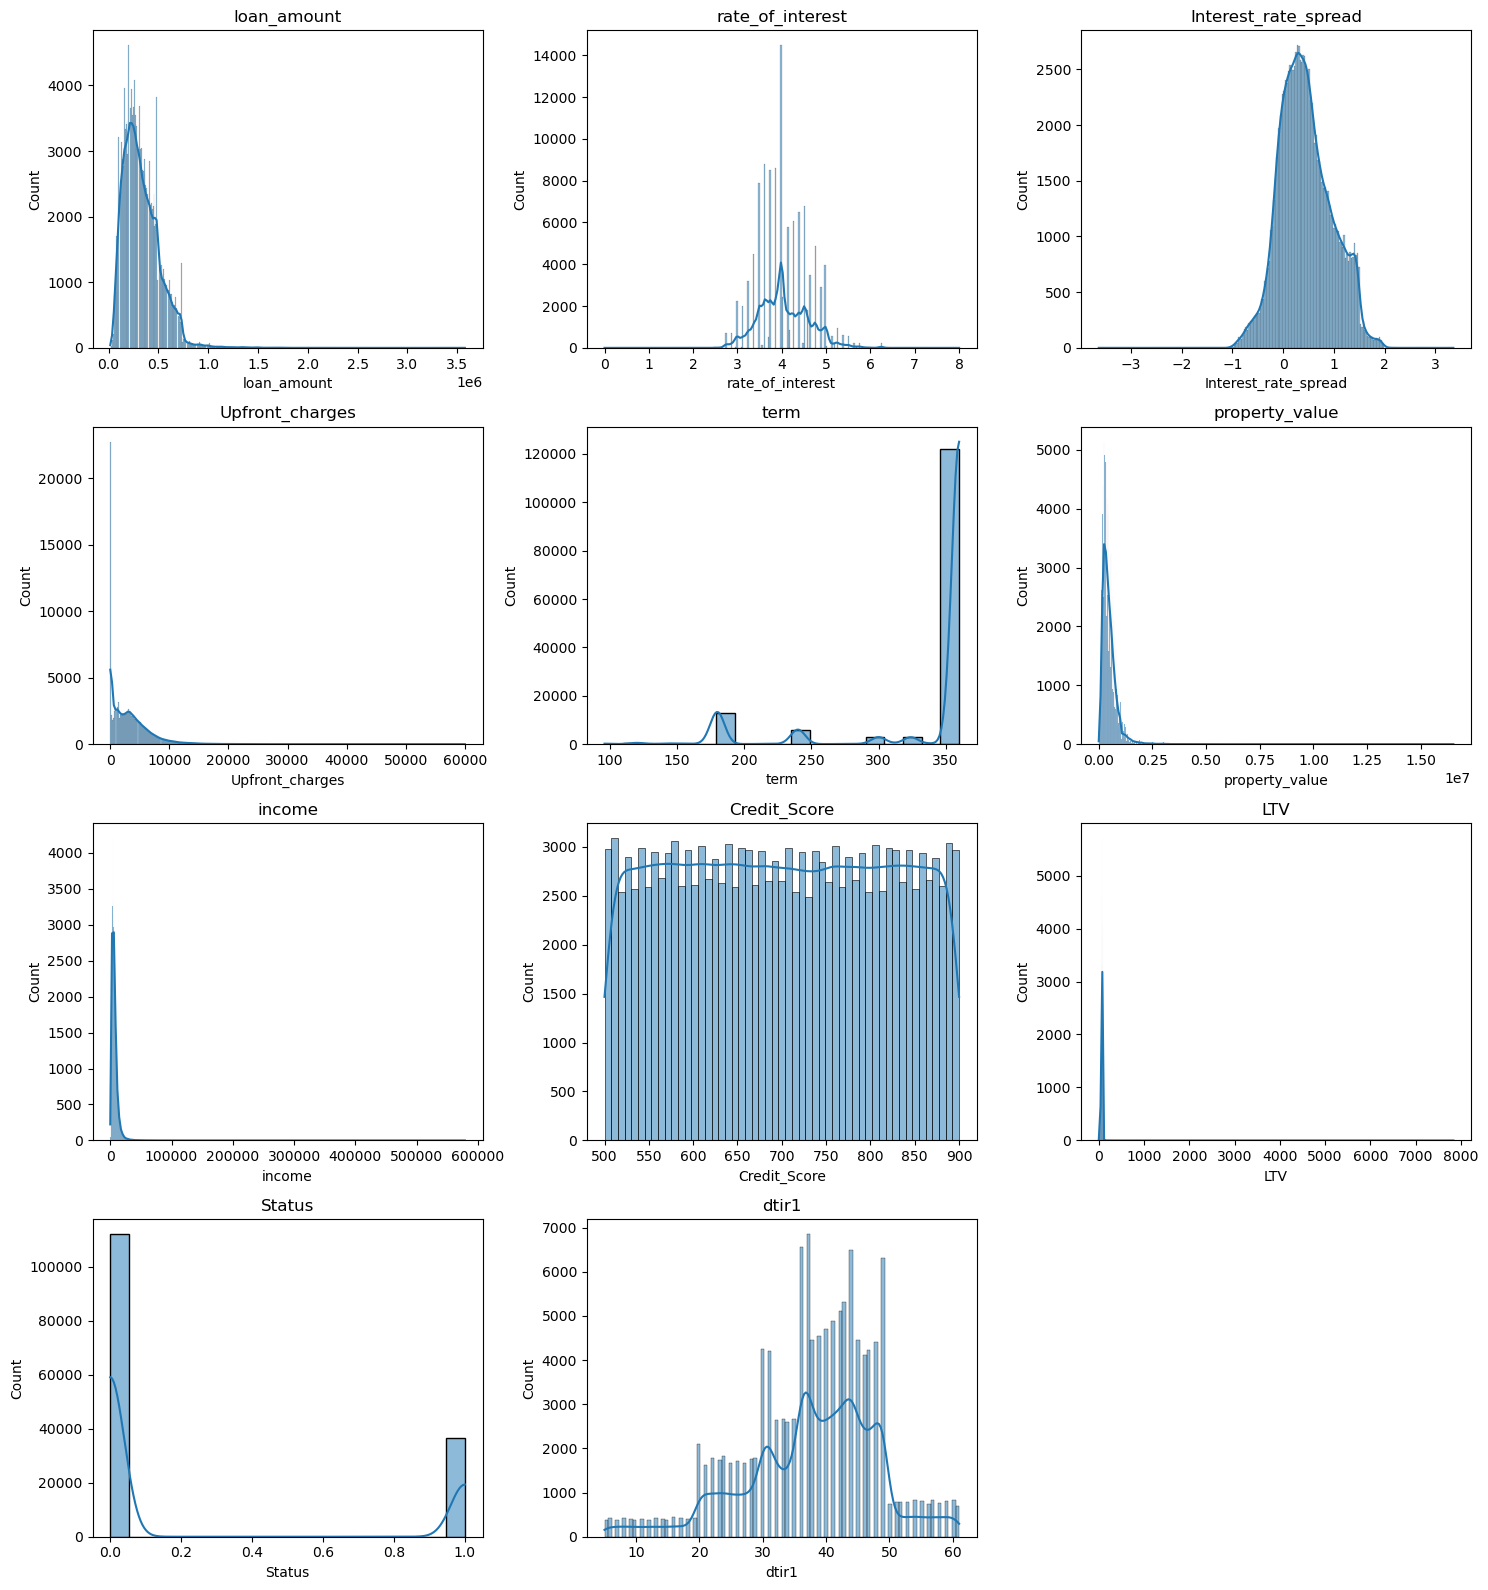

In [6]:
# check data distribution for each type. 
num_cols = df_new.select_dtypes(include=["int64","float64"]).columns
n_cols = 3
n_rows = math.ceil(len(num_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_new[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# delete empty axes. 
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based upon the above graphs: 
- loan_amount is right-skwed which means missing values will be filled with the median.
- loan_amount, upfront_charges, term, property_value, income, credit_score, LTV, and dtir need to be normalized to be in a range from 0 to 1 due to the their extreme values.
- interest_of_rate_spread and upfront_charges are slightly right skewed.
- property_value and income seem to be right-skewed but need further analysis.
- LTV has too little information need further analysis to define skeweness.
- dtir has too much variability. 
- upfront_charges has a 0 value that needs to be analyzed to see if it's a missing value or an outlier.
- Status needs to be transformed into categorical type variable. 
- LTV seems to have too little data. Needs to be quantized if there is more than 40% of missing data, it will be considered to be deleted.


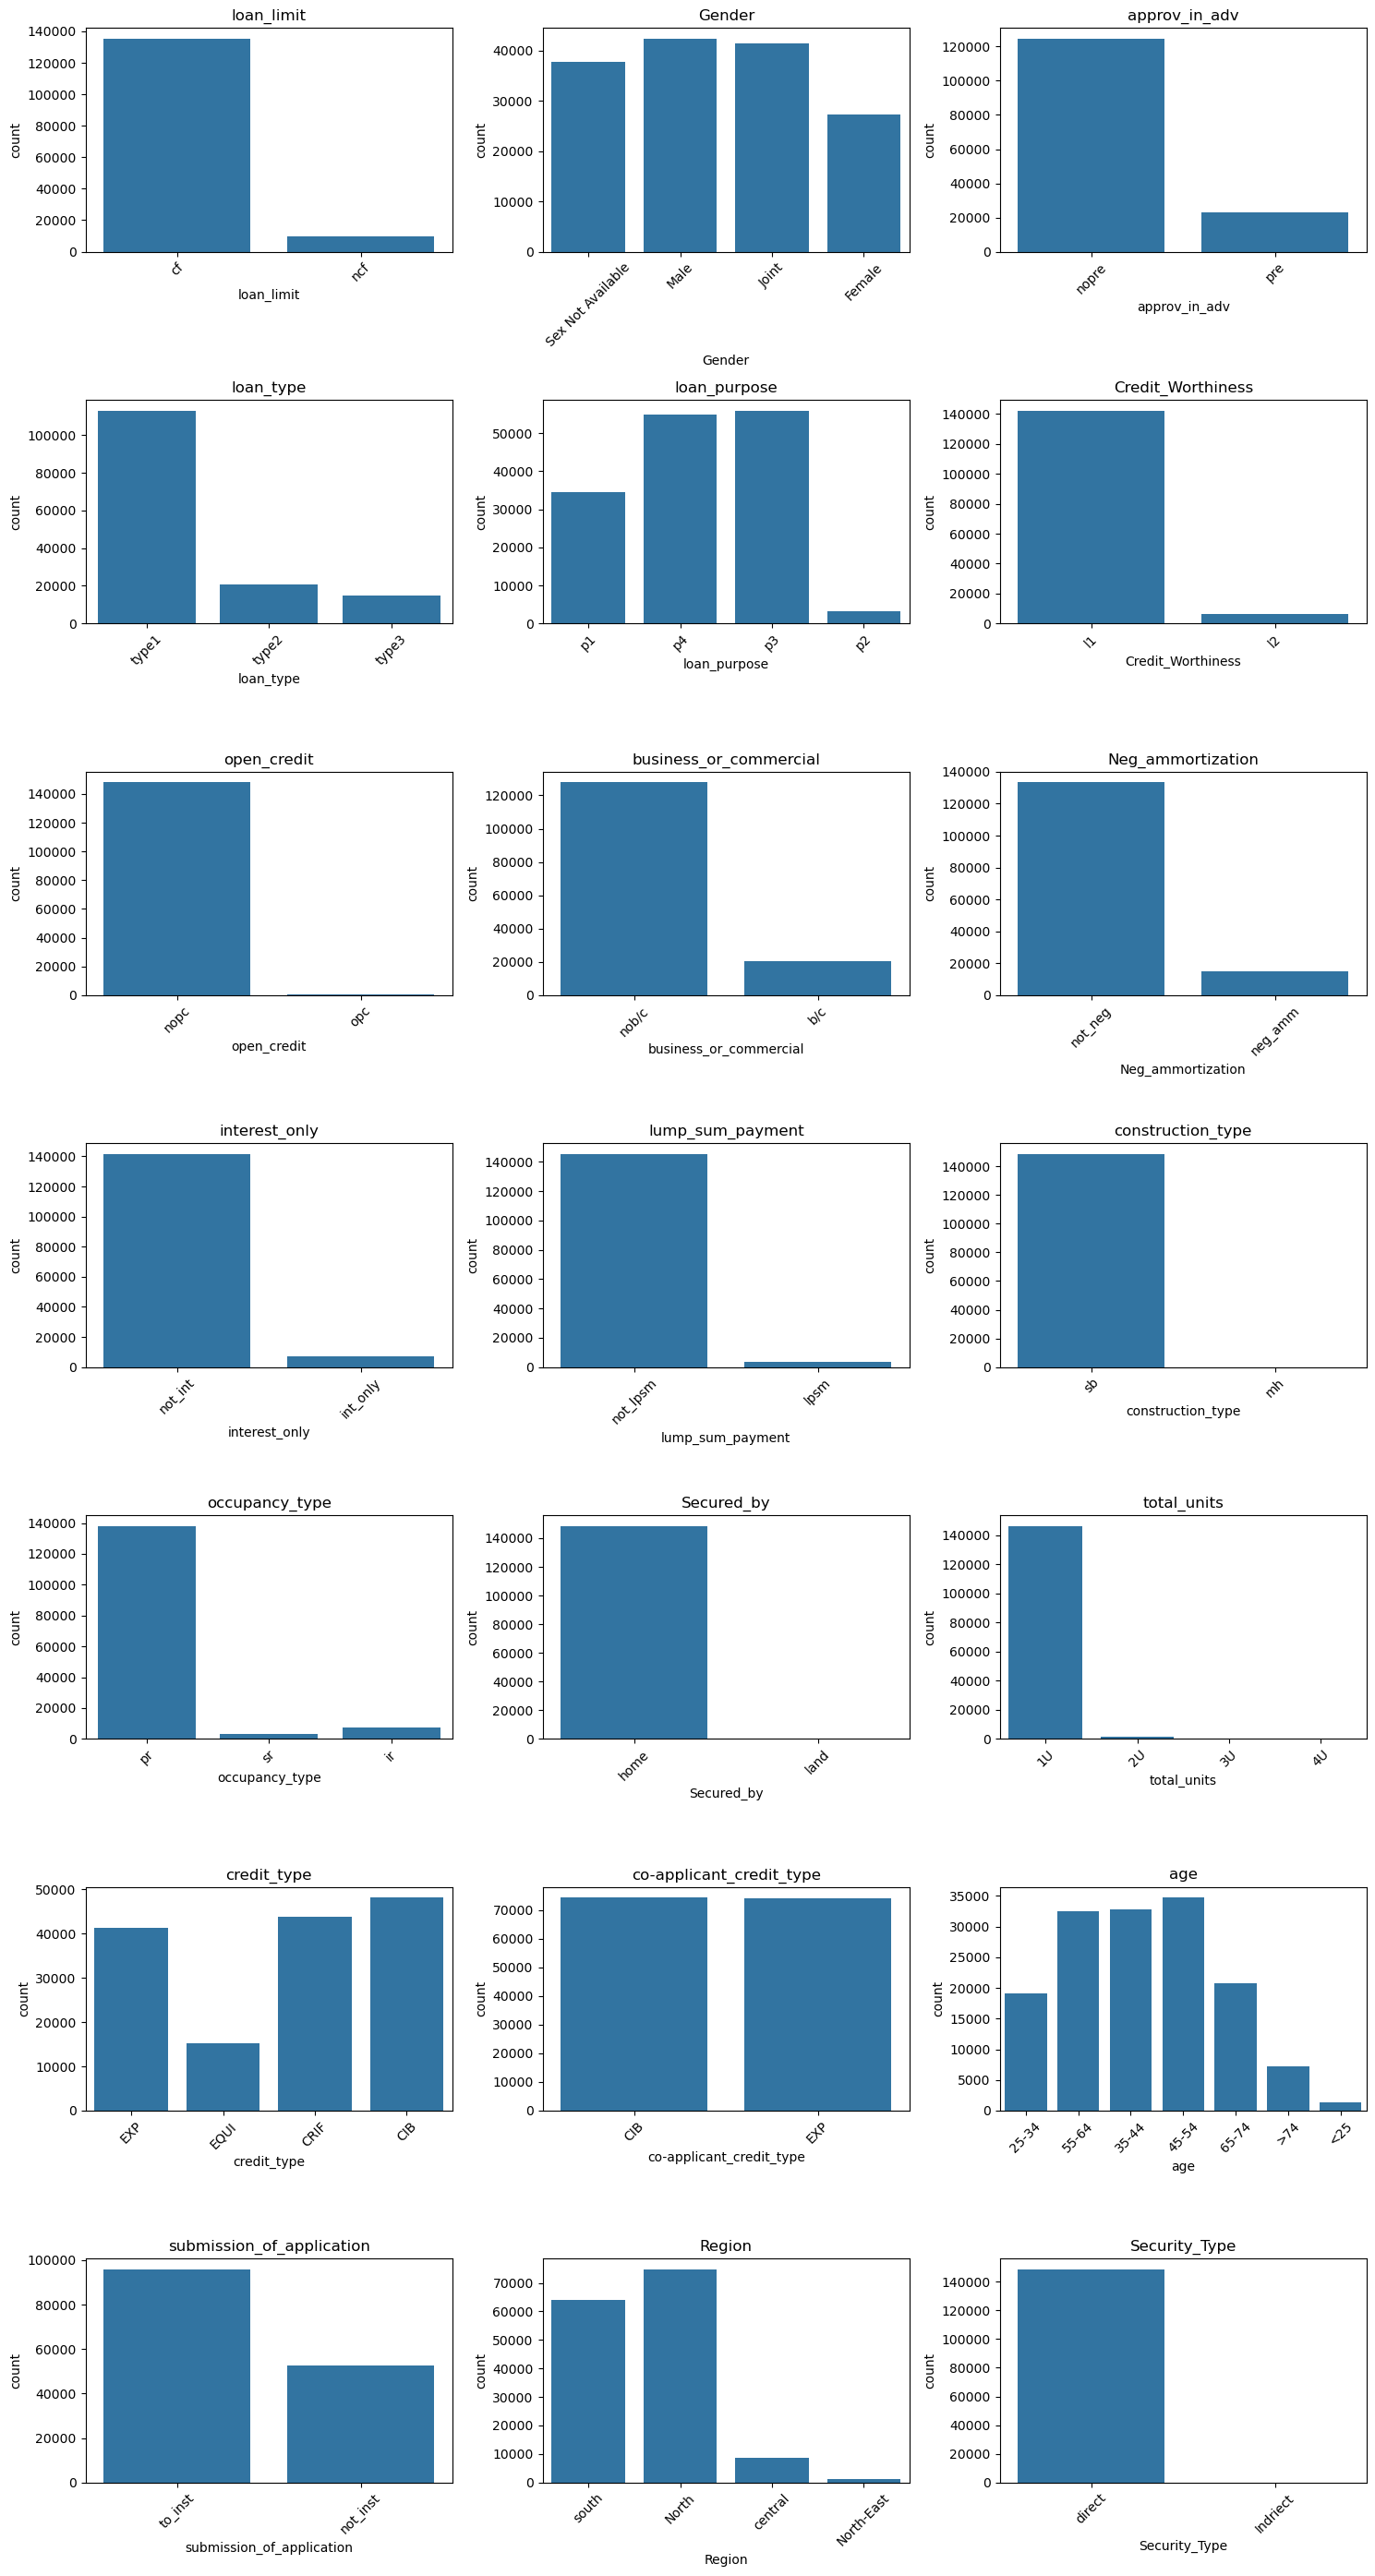

In [7]:
cat_cols = df_new.select_dtypes(include=["object","category"]).columns
n_cols = 3
n_rows = math.ceil(len(cat_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df_new[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Feature-level insights
- loan_limit (cf vs ncf)
  Conforming loans (cf) are expected to present lower default risk since they comply with underwriting standards regarding maximum amount, documentation, and borrower profile. Non-conforming loans (ncf) typically exceed these limits or fail to meet some criteria, and therefore are associated with higher interest rates and higher risk.
- Several variables show similar sample distributions: loan_limit, approv_in_adv, loan_type, business_or_commercial, interest_only, suggesting potential redundancy or strong dependency. These relations should be formally evaluated using correlation analysis and conditional distributions.
- credit source variables (EXP, EQUI, CRIF, CIB) mainly indicate the origin of credit information rather than credit quality. They should be treated as categorical features and evaluated empirically to determine whether any source is associated with higher default rates.
- Variables expected to be strong risk indicators include: loan_limit, neg_ammortization, lump_sum_payment, credit_type.

### Relationships to analyze: 
- approv_in_adv vs loan_limit
- loan_type vs loan_limit
- business_or_commercial vs loan_limit
- interest_only vs lump_sum_payment
- credit_worthiness vs loan_limit

Objective: identify redundant features and select the most informative representation. 

In [8]:
# Check if status needs a transformation. 
df_new["Status"].value_counts()

Status
0    112031
1     36639
Name: count, dtype: int64

In [9]:
# Dataset data type exploration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [10]:
# before analyzing previous relationships. Check for missing values
cols_w_missing_v = df_new.columns[df_new.isnull().any()]
print()
print(f"Columns with missing values: {len(cols_w_missing_v)}{"\n"}{cols_w_missing_v}")


Columns with missing values: 14
Index(['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'property_value', 'income', 'age', 'submission_of_application', 'LTV',
       'dtir1'],
      dtype='object')


Type of variables for columns with missing data: 
- Categorical data with missing values: loan_limit, approv_in_adv, loan_purpose, Neg_ammortization, age and submission_of_application.
- Numerical data with missing values: rate_of_interest, Interest_rate_spread, Upfront_charges, term, property_value, income, LTV and dtir1. 

In [11]:
# Counting missing values per column
def missing_data(dataframe): 
    missing_vals = dataframe.isnull().sum()
    return missing_vals.loc[missing_vals > 0]

missing_data(df_new)

loan_limit                    3344
approv_in_adv                  908
loan_purpose                   134
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
property_value               15098
income                        9150
age                            200
submission_of_application      200
LTV                          15098
dtir1                        24121
dtype: int64

In [12]:
# check % of missing values. If a column has more than 50% of missing values, it will be eliminated. 
missing_values = pd.DataFrame(missing_data(df_new), columns=["missing_values"])
missing_values["missing_pct"] = missing_values/len(df_new)*100

cols_to_drop = missing_values[missing_values["missing_pct"] >= 50].index
cols_to_drop
# No columns above 50% with missing data. 

Index([], dtype='object')

In [13]:
# check for records that have more than 50% in nan and eliminate them if any. 

missing_values_record_count = df_new.isna().sum(axis=1)
missing_values_record_count.loc[missing_values_record_count >= len(df_new.columns)/2].index

# No records to eliminate

Index([], dtype='int64')

In [14]:
# Check for duplicates
df_new.duplicated().sum()

# No duplicates

np.int64(0)

In [15]:
# Explore type of information in each column. For that let's print the unique values of each. 
for record in cat_cols: 
    
    unique_values = df_new[record].unique()
    print("\n", record, ": ", unique_values)


 loan_limit :  ['cf' nan 'ncf']

 Gender :  ['Sex Not Available' 'Male' 'Joint' 'Female']

 approv_in_adv :  ['nopre' 'pre' nan]

 loan_type :  ['type1' 'type2' 'type3']

 loan_purpose :  ['p1' 'p4' 'p3' 'p2' nan]

 Credit_Worthiness :  ['l1' 'l2']

 open_credit :  ['nopc' 'opc']

 business_or_commercial :  ['nob/c' 'b/c']

 Neg_ammortization :  ['not_neg' 'neg_amm' nan]

 interest_only :  ['not_int' 'int_only']

 lump_sum_payment :  ['not_lpsm' 'lpsm']

 construction_type :  ['sb' 'mh']

 occupancy_type :  ['pr' 'sr' 'ir']

 Secured_by :  ['home' 'land']

 total_units :  ['1U' '2U' '3U' '4U']

 credit_type :  ['EXP' 'EQUI' 'CRIF' 'CIB']

 co-applicant_credit_type :  ['CIB' 'EXP']

 age :  ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<25' nan]

 submission_of_application :  ['to_inst' 'not_inst' nan]

 Region :  ['south' 'North' 'central' 'North-East']

 Security_Type :  ['direct' 'Indriect']


Let's start treating numerical missing values. 

Highlights: 
- In banking the following are gold features, thus the nan values can not be eliminated, since they also give certain type of information. Based on research:
  
  |Feature|NAN Meaning|
  |------|-------|
  |"rate_of_interest"|not given one|
  |"Interest_rate_spread"| derived from the rate_of_interest. Formula to calculate customer_interest_rate -benchmark_rate|
  |"Upfront_charges"|client with different product or not evaluated|
  |"dtir1"| debt-to-income not calculated|
  |"property_value"| appraisal not made|
  |"income"| not declared|
  
- LTV derivates from property_value. LTV is calculated as *loan_amount/property_value*, which means that if we don't have the property value, we can't calculate it. In banking LTV is highly interpretable for determining default. A high LTV means a higher default risk. The missing values, will be kept. 

In [16]:
# fill missing values
# create missingness flags. 
# rate_of_interest -> normal distribution -> missing_values = mean
df_new["rate_of_interest_missing"] = df_new["rate_of_interest"].isna().astype(int)
df_new["rate_of_interest"] = df_new["rate_of_interest"].fillna(df_new["rate_of_interest"].mean())

# interest_rate_spread, upfront_charges, property_value, income, LTV -> 
# right skewed -> missing_value = median
# dtir1 has no defined skeweness and we are missing data to calculate. the plan is to apply a
# missing flag and insert median in missing values. 
med_cols = ["Interest_rate_spread", "Upfront_charges", "property_value", "income", "LTV", "dtir1"]

for col in med_cols: 
    df_new[col+"_missing"] = df_new[col].isna().astype(int)
    df_new[col] = df_new[col].fillna(df_new[col].median())

In [17]:
# term --> missing values = mode due to small amount of missing data. 
df_new["term"] = df_new["term"].fillna(df_new["term"].mode()[0])

now let's start treating categorical missing values

In [18]:
df_new["Status"] = df_new["Status"].astype("object")

# check relations of cateforical data vs. status. 
cat_vars = ["loan_limit", "approv_in_adv", "loan_purpose", "Neg_ammortization", "age", "submission_of_application"]

# fill na values with word missing so that they appear in crosstab. 
for col in cat_vars: 
    df_new[col+"_missing"] = df_new[col].isna().astype(int)
    df_new[col] = df_new[col].fillna("Missing")
    print("\n", pd.crosstab(df_new[col], df_new["Status"], normalize="index")*100)



 Status              0          1
loan_limit                      
Missing     73.654306  26.345694
cf          76.029199  23.970801
ncf         66.786931  33.213069

 Status                 0          1
approv_in_adv                      
Missing        73.458150  26.541850
nopre          74.672808  25.327192
pre            79.106348  20.893652

 Status                0          1
loan_purpose                      
Missing       73.880597  26.119403
p1            74.123201  25.876799
p2            66.921197  33.078803
p3            74.977652  25.022348
p4            77.025128  22.974872

 Status                     0          1
Neg_ammortization                      
Missing            73.553719  26.446281
neg_amm            55.403530  44.596470
not_neg            77.619547  22.380453

 Status           0           1
age                           
25-34    77.807962   22.192038
35-44    77.728685   22.271315
45-54    75.953341   24.046659
55-64    74.113235   25.886765
65-74    73.14

In [19]:
# Check for outliers
# Extract numeric_columns
numeric_cols = df_new.select_dtypes(exclude="object")

# Eliminate non numeric columns for the outliers analysis (such as the ones with "_missing")
numeric_cols = list(numeric_cols.columns[~numeric_cols.columns.str.contains("missing")])

# Calculate IQR
def iqr_outliers(feature):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

# Detect the outliers per column 
outlier_summary = {}
for col in numeric_cols: 
    f = df_new[col]
    lower, upper = iqr_outliers(f)

    n_outliers = ((f < lower) | (f > upper)).sum()
    outlier_summary[col] = {
        "lower": lower, 
        "upper": upper, 
        "n_outliers": n_outliers,
        "pct_outliers": round((n_outliers/len(f)*100), 2)
    }

# Check which features have possible errors, rare values, long tales or they represent subsamples. 
possible_errors = []
rare_values = []
long_tales = []
subsamples = []

for key in outlier_summary.keys(): 
    if (outlier_summary[key]["pct_outliers"] < 0.5) and (outlier_summary[key]["pct_outliers"] != 0):
        possible_errors.append(key)
    elif (outlier_summary[key]["pct_outliers"] > 0.5) and (outlier_summary[key]["pct_outliers"] < 2): 
        rare_values.append(key)
    elif (outlier_summary[key]["pct_outliers"] > 2) and (outlier_summary[key]["pct_outliers"] < 10):
        long_tales.append(key)
    else:
        subsamples.append(key)

print(f"Possible features with errors {possible_errors}")
print(f"rare values {rare_values}")
print(f"long tales {long_tales}")
print(f"subsamples {subsamples}")

Possible features with errors []
rare values ['loan_amount']
long tales ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'LTV', 'dtir1']
subsamples ['term', 'Credit_Score']


The Long tales will be the ones to watch out for a possible transformation. 

In [20]:
math.ceil(len(long_tales)/2)

4

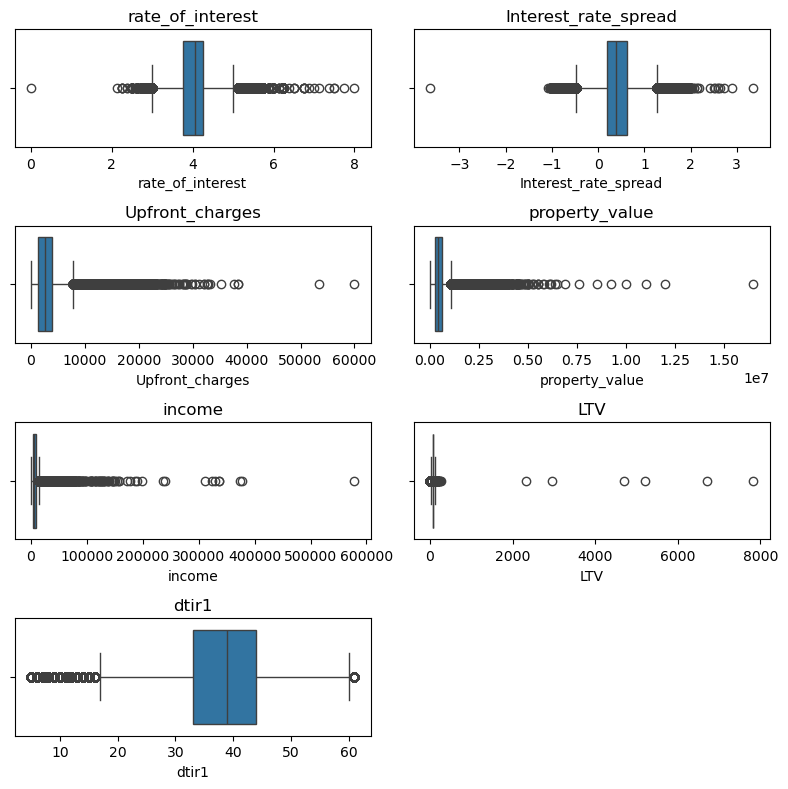

In [21]:
# plot outliers
def plot_outliers(feature, v_df):
    n_cols = 2
    n_rows = math.ceil(len(feature)/n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(feature):
        sns.boxplot(x=v_df[col], ax=axes[i])
        axes[i].set_title(col)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_outliers(long_tales, df_new)

The outliers shown above are logical, although in some circunstances like LTV, income and term present some extreme values, they represent situations that can happen in real life with some exceptional clients. However, in order to not loose information, every variable will be treated differently. 

property_value and income will not be eliminated, but transformed to: 
- Reduce asymmetry
- smooth long tales
- reduce extreme values impacts
- improve model's stability

if these two variables still present really extreme values, they will be winsorized.

upfront charges, since it is right-skewed, it can contain really extreme values, thus this variable will be transformed and winsorized. 

However rate_of_interest, interest_rate_spread, LTV and dtir1, will be winsorized instead of transformed due to the fact that these metrics are ratios. If these are transformed the linear relationship between them and the risk would be broken, eliminating the insights of risk behavior.

In [22]:
outlier_summary["rate_of_interest"]["lower"]

np.float64(3.0)

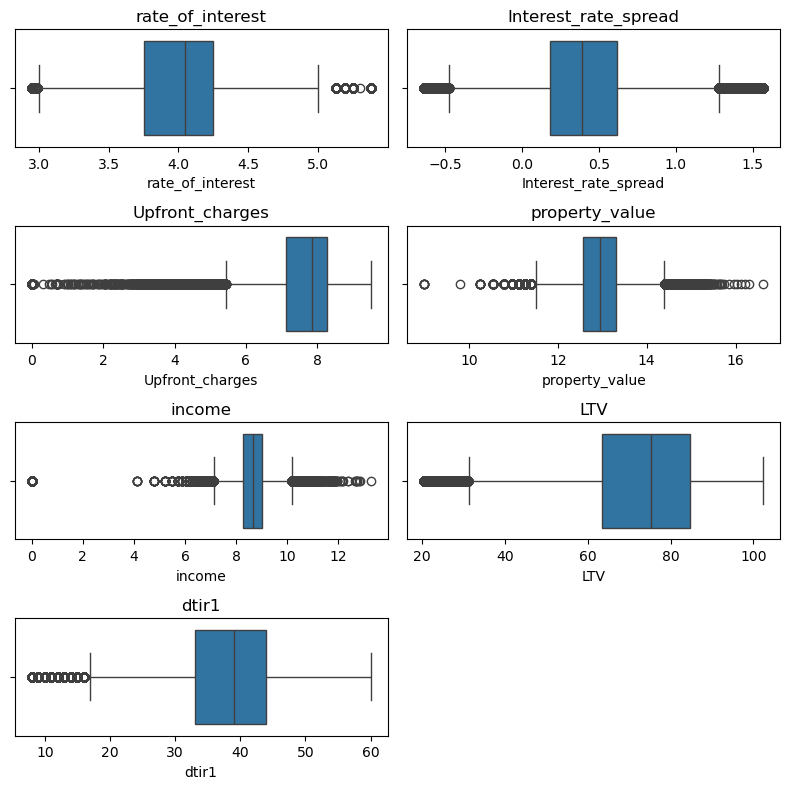

In [23]:
tales_to_transform = ["Upfront_charges", "property_value", "income"]
tales_to_winsor = ["rate_of_interest","Interest_rate_spread", "LTV", "dtir1", "Upfront_charges"]

# transform the categories
for col in tales_to_transform:
    df_new[col] = np.log1p(df_new[col])

# transform the categories
for col in tales_to_winsor:
    lower = df_new[col].quantile(0.01)
    upper = df_new[col].quantile(0.99)
    df_new[col] = df_new[col].clip(lower, upper)

# plot to see the new ranges of outliers
plot_outliers(long_tales, df_new)

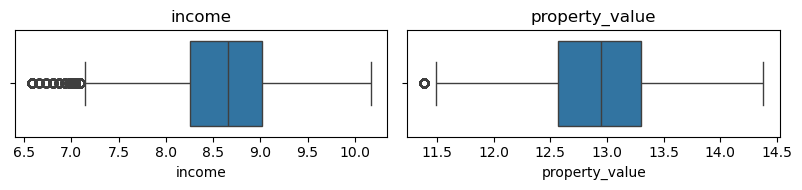

In [24]:
# winsorize income and property_value 
for col in ["income", "property_value"]:
    lower = df_new[col].quantile(0.01)
    upper = df_new[col].quantile(0.99)
    df_new[col] = df_new[col].clip(lower, upper)

# plot to see the new ranges of outliers
plot_outliers(["income","property_value"], df_new)

The outliers seem much better. Now we can start generating based on the industry some features like: 

**financial ratios**
- Loan to Income (LTI): captures direct payment capacity. 
- Upfront Charges Ratio: clients with high initial costs vs loans.
- Loan to Property Value: percentage of the property that's been financed.
- Interest Burden Proxy: approximates financial burden.

**Risk interactions**
- High LTV & Low Credit Score
- Hight DTI & Interest Only
- Non-conforming Loan flag
  
**Binning**
- Credit Score Bands
- Income Bands
- Age Bands
  
**stability flag**
- stable profile flag

In [25]:
# start building the ratios
df_new["loan_to_income"] = df_new["loan_amount"]/df_new["income"]
df_new["upfront_charges_ratio"] = df_new["Upfront_charges"]/df_new["loan_amount"]
df_new["LTPV"] = df_new["loan_amount"]/df_new["property_value"]
df_new["interest_burden"] = df_new["rate_of_interest"] * df_new["loan_amount"]

Before creating risk interactions boundaries, here are some industry standards that need to be taken into account: 

|Credit Score|Band|
|-------|-------|
|<580|Poor|
|580-669|Fair|
|670-739|Good|
|740-799|Very Good|
|>= 800|Excellent|

|LTV (%)|Interpretation|
|-------|--------------|
|<= 60%| low risk|
|60% - 80% | medium risk|
|80% - 90% | high risk|
|>90%| really high risk|

|DTI|Interpretation|
|----|-------------|
|<= 36%| Excelent|
|37% - 43%| Acceptable|
|> 43%| Risky|
|> 50%| High Risk|

In [26]:
# create the risk interactions 
df_new["high_ltv_low_score"] = ((df_new["LTV"] >= 80) & df_new["Credit_Score"] < 650).astype(int)
df_new["high_dti_int_only"] = (df_new["dtir1"] > df_new["dtir1"].median()) & (df_new["interest_only"] == "int_only")
df_new["non_cnf_flag"] = (df_new["loan_limit"] == "ncf").astype(int)

In [27]:
# Create binning features.
df_new["credit_score_band"] = pd.cut(df_new["Credit_Score"], 
                                     bins=[300, 580, 670, 740, 800, 900], 
                                     labels = ["Poor", "Fair", "Good", "Very_good", "Excellent"]
                                    )


df_new["income_band"] = pd.qcut(df_new["income"], q=4, labels=["Low", "Mid", "High", "Very_high"])

# Create Age bands
# check which categories exist. 
df_new["age"].value_counts()
age_map = {
    "<25": "Young",
    "25-34": "Young_adult", 
    "35-44": "Prime",
    "45-54": "Prime_adult",
    "55-64": "Mature", 
    "65-74": "Mature_adult", 
    ">74": "Senior",
    "Missing": "Missing"
}

df_new["age_band"] = df_new["age"].map(age_map)

pd.crosstab(df_new["age_band"], df_new["Status"], normalize="index")

Status,0,1
age_band,,
Mature,0.741132,0.258868
Mature_adult,0.731440,0.268560
Missing,0.000000,1.000000
Prime,0.777287,0.222713
Prime_adult,0.759533,0.240467
Senior,0.699930,0.300070
Young,0.710546,0.289454
Young_adult,0.778080,0.221920


In [28]:
#stable profile flag
df_new["stable_profile_flag"] = (df_new["Credit_Score"] > 670) & (df_new["dtir1"] < 43) & (df_new["LTV"] > 70)

In [29]:
# Obtain correlations between numerical features vs target.
num_data = df_new.select_dtypes(include=["float", "int"])

# Transform status to integer
num_status = df_new["Status"].astype(int)

# Add status to numerical df. 
num_data["Status"] = num_status

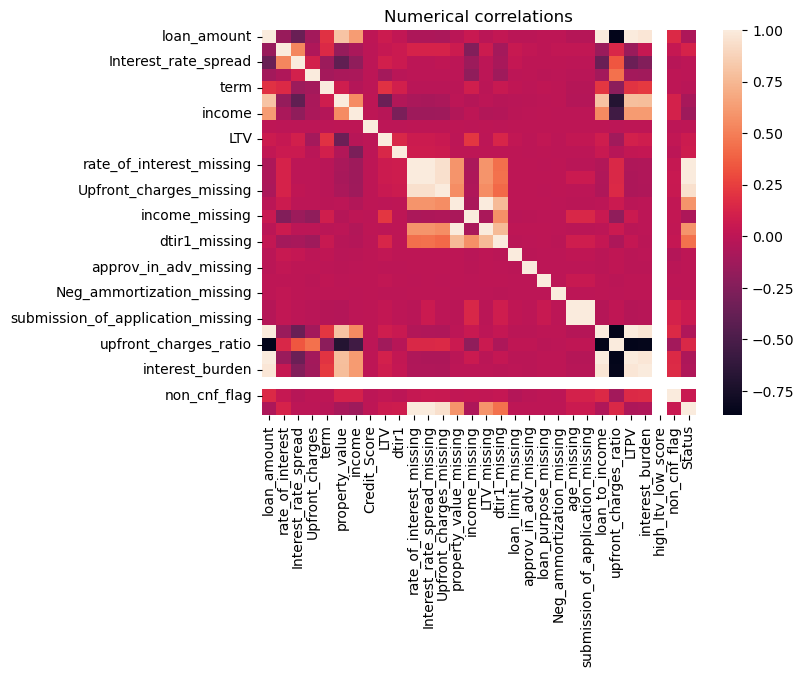

In [30]:
# check for numerical correlations
corr = num_data.corr(method="spearman")

# plot correlations
def plot_corr(matrix, title): 
    plt.figure(figsize=(7,5))
    sns.heatmap(matrix)
    plt.title(title)
    plt.show()

plot_corr(corr, "Numerical correlations")

There are a lot of correlation between lots of variables. Let's obtain the highest related pairs. 

In [31]:
# obtain high correlations pairs
def high_corr_pairs(matrix): 
    corr = matrix.abs()
    
    high_corr_pairs = (
        matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    
    high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > 0.7]
    return high_corr_pairs

high_corr_num_pairs = high_corr_pairs(corr)
print("Here are some of the most correlated pairs")
high_corr_num_pairs.sort_values(by=[0], ascending=False)

Here are some of the most correlated pairs


,level_0,level_1,0
287,property_value_missing,LTV_missing,1.000000
378,age_missing,submission_of_application_missing,1.000000
269,Interest_rate_spread_missing,Status,1.000000
24,loan_amount,LTPV,0.999003
252,rate_of_interest_missing,Status,0.996378
235,rate_of_interest_missing,Interest_rate_spread_missing,0.996378
22,loan_amount,loan_to_income,0.993791
392,loan_to_income,LTPV,0.993304
25,loan_amount,interest_burden,0.976801
400,LTPV,interest_burden,0.976727


These relations vs the target variable have high correlations. This could suggest, data leakage, thus variables will be eliminated. 
|V1|V2|Corr|
|----|------------------|--------|
|Interest_rate_spread_missing|	Status|	1.000000|
|rate_of_interest_missing|	Status|	0.996378|
|Upfront_charges_missing|	Status|	0.943005|

loan_amount, LTPV, loan_to_income and interest burden are different ratios, but mathematically related. Thus let's keep the most representative variables: LTPV (collateral risk) and loan_to_income (payment capacity)

other related variables are: property_value_missing, LTV_missing, dtir1_missing. dtir1_missing, is one of the core risk variables, therefore this variable is kept and the others eliminated. 

lastly age_missing and submission_of_application_missing are also related, however age_missing can be part of a risk profile. thus submission_of_application_missing will be eliminated. 

In [32]:
cols_to_delete = ["Interest_rate_spread_missing", "rate_of_interest_missing", "Upfront_charges_missing", 
                  "interest_burden", "property_value_missing", "LTV_missing", "submission_of_application_missing" ]
df_new = df_new.drop(columns=cols_to_delete)
df_new.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status',
       'dtir1', 'income_missing', 'dtir1_missing', 'loan_limit_missing',
       'approv_in_adv_missing', 'loan_purpose_missing',
       'Neg_ammortization_missing', 'age_missing', 'loan_to_income',
       'upfront_charges_ratio', 'LTPV', 'high_ltv_low_score',
       'high_dti_int_only', 'non_cnf_flag', 'credit_score_band', 'income_band',
       'age_band', 'stable_profile_flag'],
      dtype='object')

Let's calculate the VIF to see if it exists multicolineality between the remaining variables.

In [33]:
num_data = df_new.select_dtypes(include=["float", "int"])

In [34]:
# Calculate VIF for variables. 
def vif_calculate(df):
    X = df.copy()

    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]
    
    vif = vif.sort_values("VIF", ascending=False)
    print(vif)

#num_data = num_data.drop(columns=["Status"])
vif_calculate(num_data)

C:\Users\Daia Prado\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                      feature         VIF
19                       LTPV  895.648530
0                 loan_amount  892.027686
17             loan_to_income  198.937958
5              property_value    9.711655
6                      income    5.939386
18      upfront_charges_ratio    5.453177
8                         LTV    2.943983
2        Interest_rate_spread    2.082642
1            rate_of_interest    1.980467
10             income_missing    1.860039
11              dtir1_missing    1.700712
3             Upfront_charges    1.667472
4                        term    1.334728
9                       dtir1    1.177104
21               non_cnf_flag    1.162240
16                age_missing    1.048366
12         loan_limit_missing    1.004331
14       loan_purpose_missing    1.003009
15  Neg_ammortization_missing    1.000923
13      approv_in_adv_missing    1.000814
7                Credit_Score    1.000110
20         high_ltv_low_score    0.000000


We have extreme multicolineality with LTPV, loan_amount, loan_to_income. This is because the ratios come from similar formulas and share the numerator. LTPV = loan_amount/property_value & loan_to_income = loan_amount/income. Therefore we can eliminate them. 

LTV already integrates loan_amount and property value, thus property_value can also be eliminated. 

income has also a high vif, but it is already implied in dtir, so we can also eliminate it. 

In [35]:
cols_to_delete = ["LTPV", "loan_amount", "loan_to_income", "property_value", "income"]

df_new = df_new.drop(columns=cols_to_delete)

df_new.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status',
       'dtir1', 'income_missing', 'dtir1_missing', 'loan_limit_missing',
       'approv_in_adv_missing', 'loan_purpose_missing',
       'Neg_ammortization_missing', 'age_missing', 'upfront_charges_ratio',
       'high_ltv_low_score', 'high_dti_int_only', 'non_cnf_flag',
       'credit_score_band', 'income_band', 'age_band', 'stable_profile_flag'],
      dtype='object')

In [36]:
# recalculate vif
num_data = df_new.select_dtypes(include=["float", "int"])
vif_calculate(num_data)

                      feature         VIF
15         high_ltv_low_score  190.859766
1        Interest_rate_spread    2.015571
0            rate_of_interest    1.968456
7              income_missing    1.762672
14      upfront_charges_ratio    1.545799
8               dtir1_missing    1.525284
2             Upfront_charges    1.407353
3                        term    1.267917
5                         LTV    1.166084
13                age_missing    1.044885
6                       dtir1    1.037512
16               non_cnf_flag    1.029011
9          loan_limit_missing    1.004300
11       loan_purpose_missing    1.002972
12  Neg_ammortization_missing    1.000798
10      approv_in_adv_missing    1.000770
4                Credit_Score    1.000084


In [37]:
# delete high_ltv_low_score
df_new = df_new.drop(columns=["high_ltv_low_score"])
num_data = df_new.select_dtypes(include=["float", "int"])
vif_calculate(num_data)

                      feature        VIF
0            rate_of_interest  77.320346
3                        term  42.617069
4                Credit_Score  30.220356
5                         LTV  19.839124
6                       dtir1  16.367920
2             Upfront_charges   9.019632
14      upfront_charges_ratio   3.741504
1        Interest_rate_spread   3.324322
7              income_missing   1.826075
8               dtir1_missing   1.818505
15               non_cnf_flag   1.102512
13                age_missing   1.043484
9          loan_limit_missing   1.027162
10      approv_in_adv_missing   1.006878
11       loan_purpose_missing   1.003873
12  Neg_ammortization_missing   1.001327


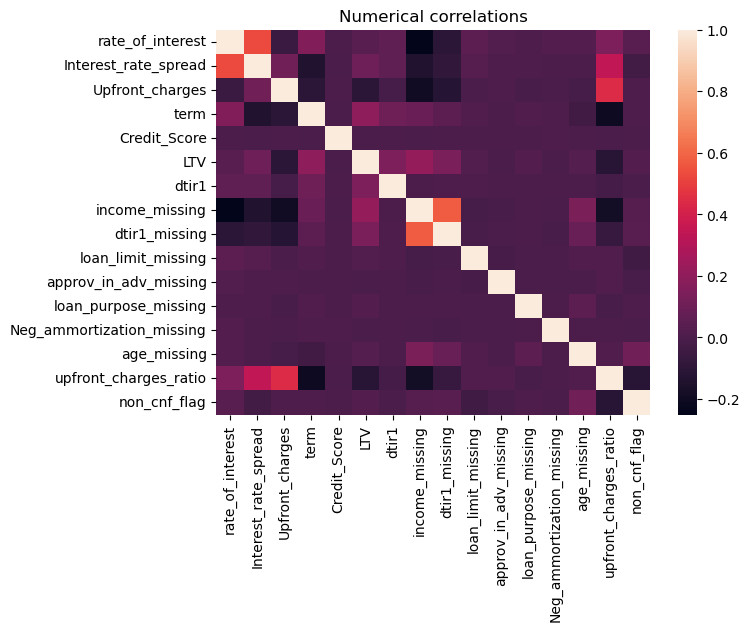

In [38]:
# check for numerical correlations
corr = num_data.corr(method="spearman")
plot_corr(corr, "Numerical correlations")

rate_of_interest shows high correlation with Interest_rate_spread. Let's eliminate Interest_rate_spread
besides there is also a high correlation between upfront_charges_ratio vs upfron_charges. Let's maintain the ratio, rather than the amount.

In [39]:
df_new = df_new.drop(columns=["Interest_rate_spread", "Upfront_charges"])
num_data = df_new.select_dtypes(include=["float", "int"])
vif_calculate(num_data)

                      feature        VIF
0            rate_of_interest  55.606130
1                        term  36.115208
2                Credit_Score  28.336408
3                         LTV  19.476930
4                       dtir1  16.280747
12      upfront_charges_ratio   2.688975
6               dtir1_missing   1.796601
5              income_missing   1.736729
13               non_cnf_flag   1.097911
11                age_missing   1.043131
7          loan_limit_missing   1.026975
8       approv_in_adv_missing   1.006761
9        loan_purpose_missing   1.003729
10  Neg_ammortization_missing   1.001231


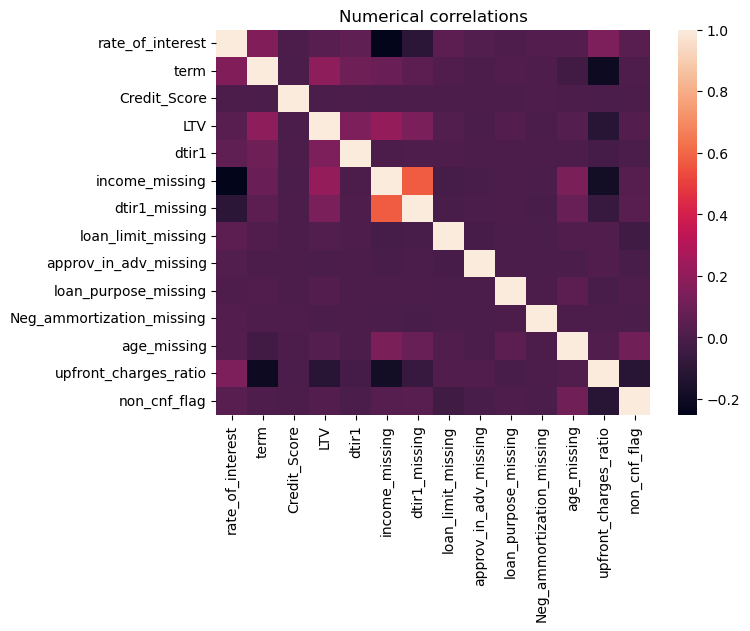

In [40]:
# check for numerical correlations
corr = num_data.corr(method="spearman")
plot_corr(corr, "Numerical correlations")

now there is a high correlation between dtir1 and income_missing, income is already inside dtir1, we can eliminate income_missing.

In [41]:
df_new = df_new.drop(columns=["income_missing"])
num_data = df_new.select_dtypes(include=["float", "int"])
vif_calculate(num_data)

                      feature        VIF
0            rate_of_interest  53.544430
1                        term  35.651235
2                Credit_Score  28.238589
3                         LTV  19.142492
4                       dtir1  16.280368
11      upfront_charges_ratio   2.669052
5               dtir1_missing   1.272834
12               non_cnf_flag   1.097878
6          loan_limit_missing   1.026730
10                age_missing   1.025521
7       approv_in_adv_missing   1.006752
8        loan_purpose_missing   1.003595
9   Neg_ammortization_missing   1.001230


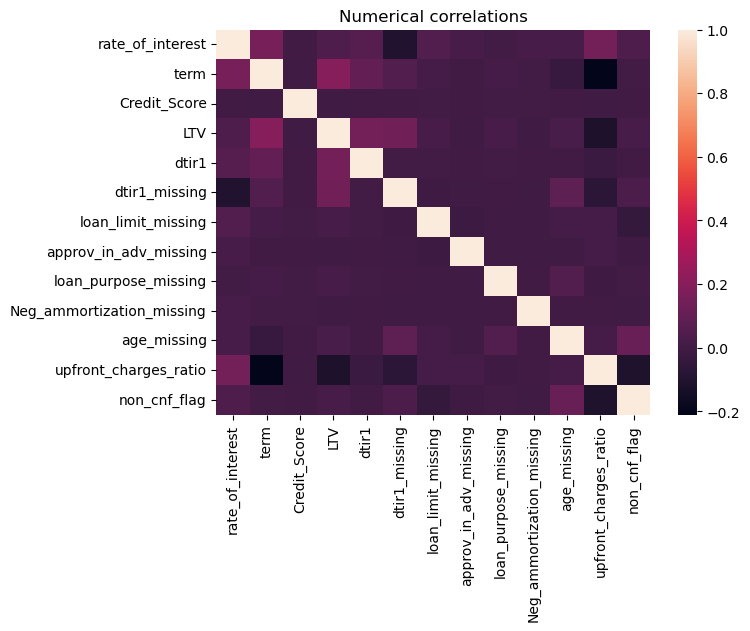

In [42]:
# check for numerical correlations
corr = num_data.corr(method="spearman")
plot_corr(corr, "Numerical correlations")

Up to this point bilateral correlations are low, however our VIF still marks strong multicolinearity. 
In order to number the quantity down, we need to start prioritizing which variables are the most important for risk detection. 
Which according to the industry are: 
- dtir1 
- LTV
- Credit_Score
- rate_of_interest. 

Leaving to eliminate: 
- term
- rate_of_interest (because it is redundant with dtir1)

In [43]:
df_new = df_new.drop(columns=["term", "rate_of_interest"])
num_data = df_new.select_dtypes(include=["float", "int"])
vif_calculate(num_data)

                      feature        VIF
0                Credit_Score  17.810881
1                         LTV  15.433398
2                       dtir1  14.301955
9       upfront_charges_ratio   2.388154
3               dtir1_missing   1.235453
10               non_cnf_flag   1.093917
4          loan_limit_missing   1.025593
8                 age_missing   1.024960
5       approv_in_adv_missing   1.006522
6        loan_purpose_missing   1.003575
7   Neg_ammortization_missing   1.000913


The VIF still marks a high correlation in credit_score, LTV and dtir1, but it is in tolerable ranges. 
The fact that Credit_Score, LTV and dtir1 are correlated is normal and expected for credit risk, because they all measure payment/risk capacity. 
In credit, default depends mainly of: 
- payment capacity
- payment incentive
- Behaviour history

These 3 variables capture those dimensions. 
- Credit_score resumes past behaviours such as, delayed payments, loan usage, history, in other words it's a historical measure of risk. 
- LTV (Loan-to-Value) measures equity and if the value of the active falls. It is a measure of economic incentive. 
- dtir1 (Debt-to-Income Ratio) measures the actual payment capacity. It is a measure of liquity. 

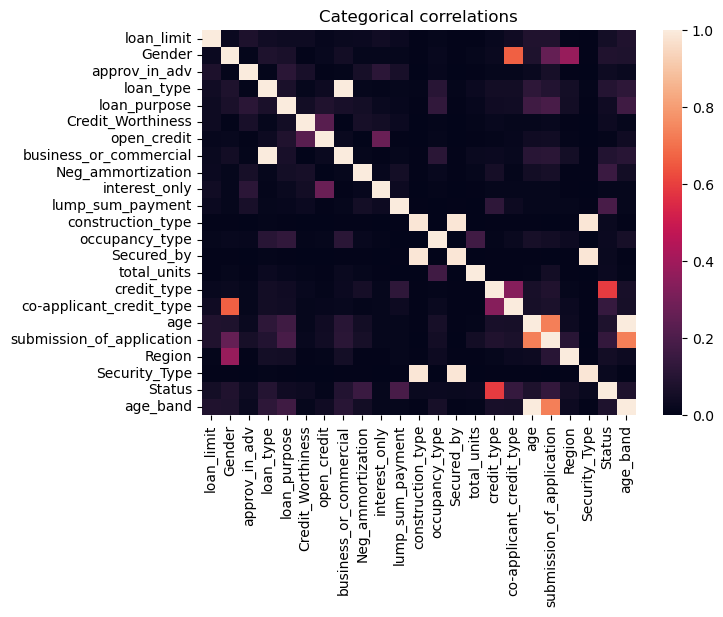

In [58]:
# Check for categorical correlation
# Obtain object type columns
cat_cols = df_new.select_dtypes(include="object").columns

cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

# Calculate Cramer's v 
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency) # Calculate squared-chi
    n = contingency.to_numpy().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


for f in cat_cols:
 for c in cat_cols:
     cramer_matrix.loc[f, c] = cramers_v(df_new[f], df_new[c])

# plot correlations
plot_corr(cramer_matrix, "Categorical correlations")

In [59]:
# Obtain the high correlated pairs
high_corr_cat_pairs = high_corr_pairs(cramer_matrix)
high_corr_cat_pairs

,level_0,level_1,0
66,loan_type,business_or_commercial,1.000000
188,construction_type,Secured_by,0.984845
195,construction_type,Security_Type,0.984845
214,Secured_by,Security_Type,0.984845
238,age,submission_of_application,0.732350
242,age,age_band,1.000000
246,submission_of_application,age_band,0.732350


The table shows high correlation between loan_type vs business_or_commercial. In this case, it is more interpretable to maintain business_or_commercial variable, this variable is binary and has less dimensionality and eliminate loan_type. 

construction_type, secured_by and security_type are also strongly related. However, the variable that will be kept is construction_type since it tells you more about the risk, because ir captures active liquity and has recovery implications. 

age vs age_band, since age is presented as range, it is more interpretable to stay with age_band, because it is easier to check if it is a young or senior person. 

Eventhough, submission_of_application and age are correlated, submission_of_application will be kept since it define wether the loan was directly solicited or through a third party. 

In [60]:
cols_to_delete = ["loan_type", "Secured_by", "Security_Type", "age"]
df_new = df_new.drop(columns=cols_to_delete)

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'construction_type', 'occupancy_type', 'total_units', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'submission_of_application',
       'LTV', 'Region', 'Status', 'dtir1', 'dtir1_missing',
       'loan_limit_missing', 'approv_in_adv_missing', 'loan_purpose_missing',
       'Neg_ammortization_missing', 'age_missing', 'upfront_charges_ratio',
       'high_dti_int_only', 'non_cnf_flag', 'credit_score_band', 'income_band',
       'age_band', 'stable_profile_flag'],
      dtype='object')

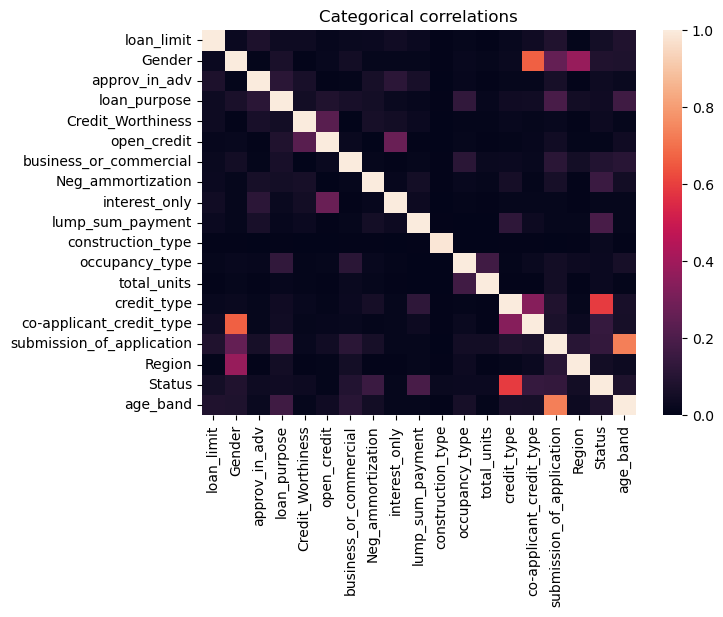

In [61]:
cat_cols = df_new.select_dtypes(include="object").columns

cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

# Calculate Cramer's v 
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency) # Calculate squared-chi
    n = contingency.to_numpy().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


for f in cat_cols:
 for c in cat_cols:
     cramer_matrix.loc[f, c] = cramers_v(df_new[f], df_new[c])

# plot correlations
plot_corr(cramer_matrix, "Categorical correlations")

In [62]:
# Obtain the high correlated pairs
high_corr_cat_pairs = high_corr_pairs(cramer_matrix)
high_corr_cat_pairs

,level_0,level_1,0
167,submission_of_application,age_band,0.73235


There are no more high_correlated pairs to delete. 

In [77]:
# Transform Status to integer
df_new["Status"] = df_new["Status"].astype(int)
df_new["Status"].dtypes

dtype('int64')

In [78]:
# split X and Y
X = df_new.drop(columns="Status")
y = df_new["Status"]

# Define types of variables for future encoding. 
num_cols = X.select_dtypes(include=["int", "float"]).columns.tolist()
cat_nominal = ['Gender','loan_purpose', 'occupancy_type',
               'credit_type','co-applicant_credit_type', 'loan_limit',
               'approv_in_adv', 'Neg_ammortization', 'submission_of_application'
              ]
cat_ordinal = ['total_units', 'age_band']
cat_bin = ['Credit_Worthiness', 'open_credit',
           'business_or_commercial','interest_only',
           'lump_sum_payment', 'construction_type'
          ]


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

cat_ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("ordinalencoder", OrdinalEncoder(categories=[["1U","2U","3U","4U"],
                                                  ["Young", "Young_adult",
                                                  "Prime", "Prime_adult",
                                                  "Mature", "Mature_adult",
                                                  "Senior", "Missing"]]))
])

cat_bin_pipeline = Pipeline([
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols), 
    ("cat", cat_pipeline, cat_nominal),
    ("cat_ord", cat_ord_pipeline, cat_ordinal),
    ("cat_bin", cat_bin_pipeline, cat_bin)
])

Accuracy: 0.87
AUC: 0.84
Best threshold: 0.39
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     22406
           1       0.86      0.55      0.67      7328

    accuracy                           0.87     29734
   macro avg       0.86      0.76      0.79     29734
weighted avg       0.87      0.87      0.85     29734



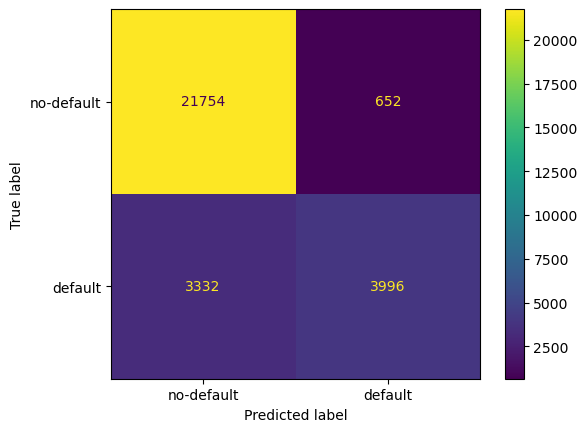

In [99]:
# Train your model for Logistic regression
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

print(f"Accuracy: {model.score(X_test, y_test):.2f}")

y_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.2f}")

# choose best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

f1 = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1.argmax()]
print(f"Best threshold: {best_threshold:.2f}")

y_pred = (y_proba >= best_threshold).astype(int)

# print classification_report 
print(classification_report(y_test, y_pred))

# confusion_matrix 
cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no-default","default"])
cm_display.plot()
plt.show()